In [38]:
import os
import argparse
import json

import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from scipy.io.wavfile import write as wavwrite
from scipy.io.wavfile import read as wavread

from util import rescale, find_max_epoch, print_size, sampling, calc_diffusion_hyperparams
from models import WaveNet_vocoder as WaveNet

def generate(output_directory, tensorboard_directory,
             mel_path, condition_name,
             ckpt_path, ckpt_iter):
    """
    Generate audio based on ground truth mel spectrogram

    Parameters:
    output_directory (str):         save generated speeches to this path
    tensorboard_directory (str):    save tensorboard events to this path
    mel_path (str):                 ground truth mel spectrogram path
    condition_name (str):           name of ground truth mel spectrogram to be conditioned on
                                    e.g. LJ001-0001
    ckpt_path (str):                checkpoint path
    ckpt_iter (int or 'max'):       the pretrained checkpoint to be loaded; 
                                    automitically selects the maximum iteration if 'max' is selected
    """

    # generate experiment (local) path
    local_path = "ch{}_T{}_betaT{}".format(wavenet_config["res_channels"], 
                                           diffusion_config["T"], 
                                           diffusion_config["beta_T"])

    # Get shared output_directory ready
    output_directory = os.path.join('exp', local_path, output_directory)
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
    print("output directory", output_directory, flush=True)

    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key is not "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    # predefine model
    net = WaveNet(**wavenet_config).cuda()
    print_size(net)

    # load checkpoint
    ckpt_path = os.path.join('exp', local_path, ckpt_path)
    if ckpt_iter == 'max':
        ckpt_iter = find_max_epoch(ckpt_path)
    model_path = os.path.join(ckpt_path, '{}.pkl'.format(ckpt_iter))
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        net.load_state_dict(checkpoint['model_state_dict'])
        print('Successfully loaded model at iteration {}'.format(ckpt_iter))
    except:
        raise Exception('No valid model found')
    
    # use ground truth mel spec
    #try:
    #    ground_truth_mel_name = os.path.join(mel_path, '{}.wav.pt'.format(condition_name))
    #    ground_truth_mel_spectrogram = torch.load(ground_truth_mel_name).unsqueeze(0).cuda()
    #except:
     #   raise Exception('No ground truth mel spectrogram found')
   # audio_length = ground_truth_mel_spectrogram.shape[-1] * trainset_config["hop_length"]
    audio_length = 1125
    print('begin generating audio of length %s' % audio_length)

    # inference
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    generated_audio = sampling(net, (1,22,audio_length),
                            diffusion_hyperparams, 
                            condition=1)

    end.record()
    torch.cuda.synchronize()
    print('generated {} at iteration {} in {} seconds'.format(condition_name, 
                                                              ckpt_iter, 
                                                              int(start.elapsed_time(end)/1000)))

    # save generated data to .txt
    outfile = '{}_{}_{}k_{}.txt'.format(wavenet_config["res_channels"],
                                        diffusion_config["T"], 
                                        ckpt_iter // 1000, 
                                        condition_name)

    with open(outfile, 'w') as f:
        f.write(str(generated_audio.squeeze().cpu().numpy()))


    # save eeg to tensorboard
   # tb = SummaryWriter(os.path.join('exp', local_path, tensorboard_directory))
   # tb.add_audio(tag=outfile, snd_tensor=generated_audio.squeeze(0), sample_rate=trainset_config["sampling_rate"])
   # tb.close()

    print('saved generated samples at iteration %s' % ckpt_iter)
    return generated_audio.squeeze().cpu().numpy()

if __name__ == "__main__":
    # Parse configs. Globals nicer in this case
    with open('configure.json') as f:
        data = f.read()
    config = json.loads(data)
    gen_config              = config["gen_config"]
    global wavenet_config
    wavenet_config          = config["wavenet_config"]      # to define wavenet
    global diffusion_config 
    diffusion_config        = config["diffusion_config"]    # basic hyperparameters
    global trainset_config
    trainset_config         = config["trainset_config"]     # to read trainset configurations
    global diffusion_hyperparams
    diffusion_hyperparams   = calc_diffusion_hyperparams(**diffusion_config)  # dictionary of all diffusion hyperparameters

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    data = generate(**gen_config,
             ckpt_iter='max',
             condition_name='uncondition')

output directory exp\ch1_T200_betaT0.02\speeches
WaveNet_vocoder Parameters: 0.351368M


<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\YLY\AppData\Local\Temp\ipykernel_26792\742533229.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if key is not "T":


Successfully loaded model at iteration 80000
begin generating audio of length 1125
begin sampling, total number of reverse steps = 200
generated uncondition at iteration 80000 in 4 seconds
saved generated samples at iteration 80000


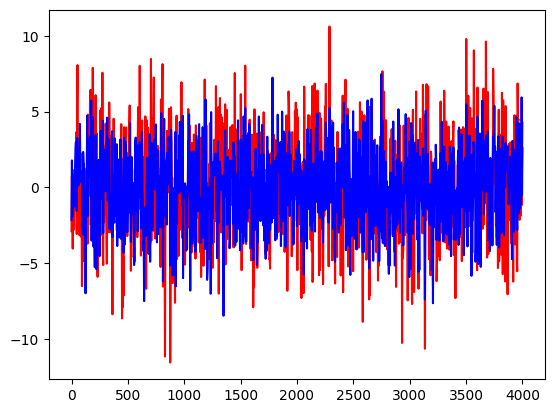

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, 4000, num=1125), data[1,:],'r')
plt.plot(np.linspace(0, 4000, num=1125), data[2,:],'b')

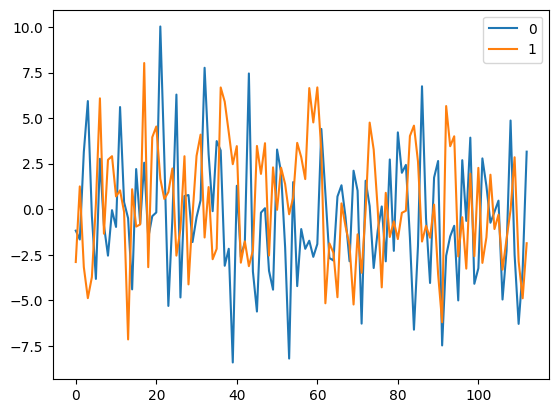

In [40]:
import pandas as pd
pd.DataFrame(data[0:2,::10]).T.plot()
plt.show()

Creating RawArray with float64 data, n_channels=22, n_times=1125
    Range : 0 ... 1124 =      0.000 ...     4.496 secs
Ready.
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB



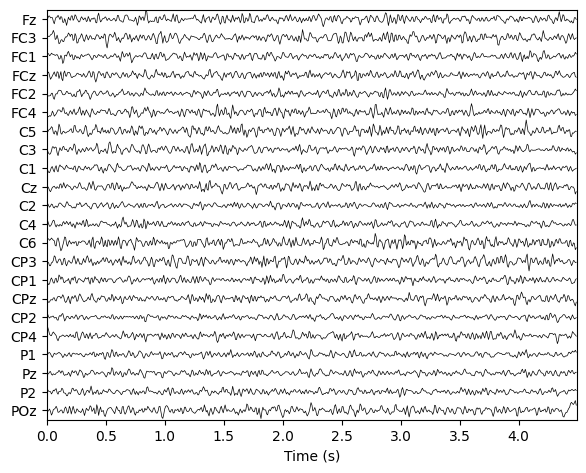

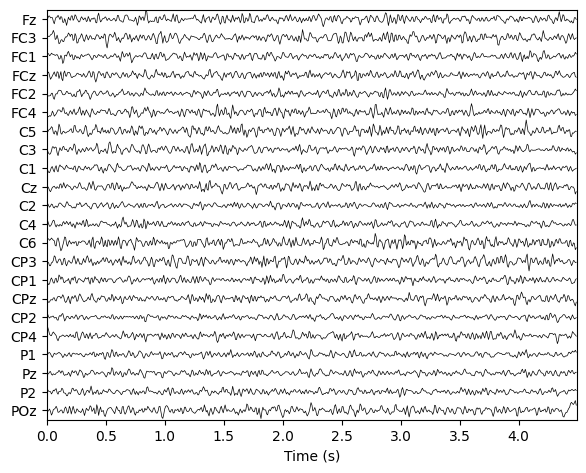

In [62]:
import mne
# Create some dummy metadata
n_channels = 22
sampling_freq = 250  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)

ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
ch_types = ['eeg'] * 22
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('easycap-M1')
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot(n_channels=22,scalings=6,remove_dc=True,highpass=4,lowpass=40,show_scrollbars=False, show_scalebars=False)

In [43]:
data.shape

(22, 1125)

(2, 250)